In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import sys

In [48]:
# General configs

EXPERIMENT_FOLDER = 'both_experiments'
FIGURE_FOLDER = os.path.join("outputs", EXPERIMENT_FOLDER)
FILTER_BY_APPLE_VARIETY = False # Currently NOT IMPLEMENTED
APPLE_VARIETY = "Envy-Vetzan"
K_N_SPLITS=3
TEST_SIZE=0.1

if not os.path.exists(FIGURE_FOLDER):
    os.makedirs(FIGURE_FOLDER)

OUTPUT_LOG_FILE = os.path.join(FIGURE_FOLDER, EXPERIMENT_FOLDER + ".log")
original_stdout = sys.stdout
stdout_redirected = open(OUTPUT_LOG_FILE, 'w')
sys.stdout = stdout_redirected

In [49]:
# Data parsing

LABELS               = []
FREQUENCIES          = []
IMPEDANCE_RESPONSE   = []
PHASE_SHIFT_RESPONSE = []
INSTRUMENTAL_COLUMNS = ["Felix sunny","Felix shaddy","DA meter sunny","DA meter shaddy","Refractometer Sunny","Refractometer Shady","Dynamometer Sunny","Dynamometer Shady", "Observations after cutting", "Internal Browning"]
INSTRUMENTAL_DATA    = np.empty((0, len(INSTRUMENTAL_COLUMNS)))

impedance_filepath = os.path.join("dataset", EXPERIMENT_FOLDER, "impedance.csv")
phs_filepath       = os.path.join("dataset", EXPERIMENT_FOLDER, "phase_shift.csv")
instrumental_fp    = os.path.join("dataset", EXPERIMENT_FOLDER, "instrumental.csv")
impedance_df       = pd.read_csv(impedance_filepath)
phs_df             = pd.read_csv(phs_filepath)
instrumental_df    = pd.read_csv(instrumental_fp)

FREQUENCIES = [float(x) for x in impedance_df.columns[3:].tolist()]
for val in impedance_df.values:
    if not FILTER_BY_APPLE_VARIETY or val[1].startswith(APPLE_VARIETY):
        if val[0] == 'No Browning':
            LABELS.append(0)
        else:
            LABELS.append(1)
for val in impedance_df.values:
    if not FILTER_BY_APPLE_VARIETY or val[1].startswith(APPLE_VARIETY):
        impedance_values = [float(x) for x in val[3:].tolist()]
        IMPEDANCE_RESPONSE.append(impedance_values)
for val in phs_df.values:
    if not FILTER_BY_APPLE_VARIETY or val[1].startswith(APPLE_VARIETY):
        phs_values = [float(x) for x in val[3:].tolist()]
        PHASE_SHIFT_RESPONSE.append(phs_values)
for val in instrumental_df.values:
    # if not FILTER_BY_APPLE_VARIETY or phs_df.values[i][1].startswith(APPLE_VARIETY):
    INSTRUMENTAL_DATA = np.vstack([INSTRUMENTAL_DATA, val])

INSTRUMENTAL_DATA_LABELS = np.vectorize(lambda label: 0 if label == "No Browning" else 1)(INSTRUMENTAL_DATA[:, -1])
assert(INSTRUMENTAL_DATA_LABELS.all() == np.array(LABELS).all())
INSTRUMENTAL_DATA_TABLE  = np.array(INSTRUMENTAL_DATA[:, :-2])

/tmp/ipykernel_7175/1493833232.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.real((np.polyval(ampl_coeffs, s)) * math.exp(np.polyval(phs_coeffs, s) * 1j))


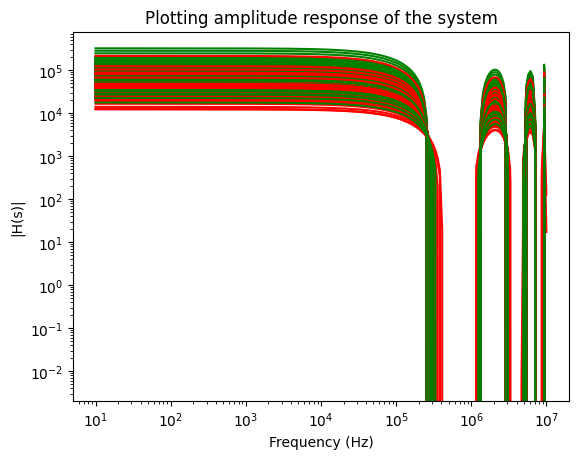

In [50]:
# Trying to model the apple as a system (from signal processing theory)
# and then trying to compute the frequency response
# As the plot suggests, the frequency response alone it is not useful

IFFT_BROWNED_APPLES = np.empty((0, len(FREQUENCIES)))
IFFT_NOT_BROWNED_APPLES = np.empty((0, len(FREQUENCIES)))

def absH(s, ampl_coeffs, phs_coeffs):
    return np.real((np.polyval(ampl_coeffs, s)) * math.exp(np.polyval(phs_coeffs, s) * 1j))

for i in range(0, len(LABELS) - 1):
    impcoeffs = np.polyfit(FREQUENCIES, IMPEDANCE_RESPONSE[i], 7)
    phscoeffs = np.polyfit(FREQUENCIES, PHASE_SHIFT_RESPONSE[i], 7)
    ys = [absH(frequency, impcoeffs, phscoeffs) for frequency in FREQUENCIES]
    ifft_ys = np.fft.ifft(ys)
    plt.title('Plotting amplitude response of the system')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|H(s)|")
    if LABELS[i]:
        plt.plot(FREQUENCIES, ys, 'r')
        IFFT_BROWNED_APPLES = np.vstack([IFFT_BROWNED_APPLES, ifft_ys])
    else:
        plt.plot(FREQUENCIES, ys, 'g')
        IFFT_NOT_BROWNED_APPLES = np.vstack([IFFT_NOT_BROWNED_APPLES, ifft_ys])


plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_frequency_response.png"))

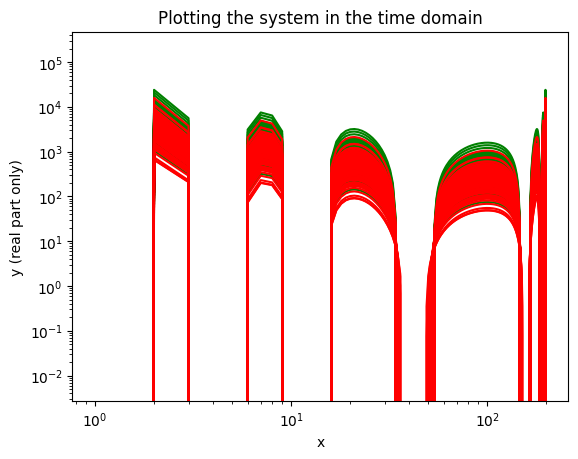

In [51]:
def get_real_part(a):
    return [y for y in np.real(a)]

xs = np.arange(0, len(FREQUENCIES))

plt.title('Plotting the system in the time domain')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('y (real part only)')


for v in IFFT_NOT_BROWNED_APPLES:
    plt.plot(xs, get_real_part(v), 'g')
for v in IFFT_BROWNED_APPLES:
    plt.plot(xs, get_real_part(v), 'r')
    
plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_system_in_time_domain.png"))

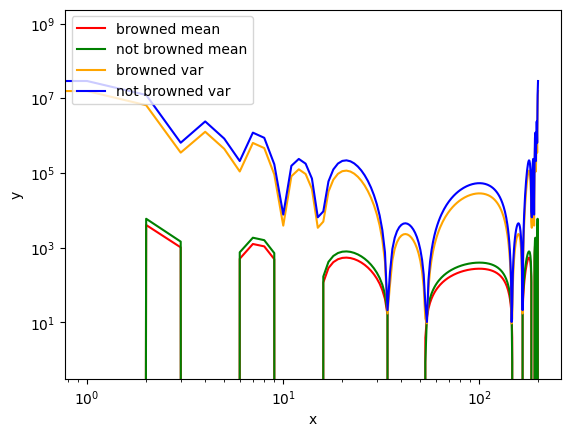

In [52]:
# Plotting mean and variance

IFFT_BROWNED_APPLES_REAL_PART = np.empty((0, len(FREQUENCIES)))
IFFT_NOT_BROWNED_APPLES_REAL_PART = np.empty((0, len(FREQUENCIES)))
IFFT_BROWNED_APPLES_REAL_PART = np.empty((0, len(FREQUENCIES)))
IFFT_NOT_BROWNED_APPLES_REAL_PART = np.empty((0, len(FREQUENCIES)))

for i in range(0, len(IFFT_BROWNED_APPLES) - 1):
    IFFT_BROWNED_APPLES_REAL_PART      = [a for a in get_real_part(IFFT_BROWNED_APPLES)]    
    IFFT_NOT_BROWNED_APPLES_REAL_PART  = [a for a in get_real_part(IFFT_NOT_BROWNED_APPLES)]
    IFFT_BROWNED_APPLES_REAL_PART      = [a for a in get_real_part(IFFT_BROWNED_APPLES)]
    IFFT_NOT_BROWNED_APPLES_REAL_PART  = [a for a in get_real_part(IFFT_NOT_BROWNED_APPLES)]


IFFT_BROWNED_APPLES_MEAN         = np.mean(IFFT_BROWNED_APPLES_REAL_PART, axis=0)
IFFT_NOT_BROWNED_APPLES_MEAN     = np.mean(IFFT_NOT_BROWNED_APPLES_REAL_PART, axis=0)
IFFT_BROWNED_APPLES_VARIANCE     = np.var(IFFT_BROWNED_APPLES_REAL_PART, axis=0)
IFFT_NOT_BROWNED_APPLES_VARIANCE = np.var(IFFT_NOT_BROWNED_APPLES_REAL_PART, axis=0)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('y')

xs = np.arange(0, len(IFFT_BROWNED_APPLES_MEAN))

plt.plot(xs, IFFT_BROWNED_APPLES_MEAN, 'red', label='browned mean')
plt.plot(xs, IFFT_NOT_BROWNED_APPLES_MEAN, 'green', label='not browned mean')
plt.plot(xs, IFFT_BROWNED_APPLES_VARIANCE, 'orange', label='browned var')
plt.plot(xs, IFFT_NOT_BROWNED_APPLES_VARIANCE, 'blue', label='not browned var')
plt.legend(loc="upper left")

plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_system_in_time_domain_mean_and_variance.png"))

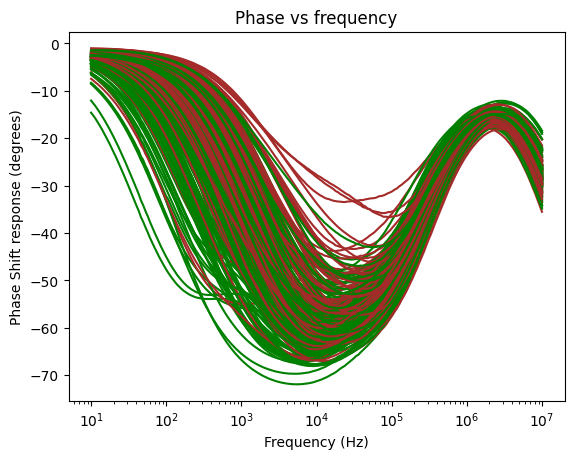

In [53]:
# General plotting to visualize the data

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Shift response (degrees)')
plt.title("Phase vs frequency")
plt.xscale('log')

for i in range(0, len(LABELS) - 1):
    label = LABELS[i]
    impedance = IMPEDANCE_RESPONSE[i]
    phase_shift = PHASE_SHIFT_RESPONSE[i]
    if label:
        plt.plot(FREQUENCIES, PHASE_SHIFT_RESPONSE[i], 'brown')
    else:
        plt.plot(FREQUENCIES, PHASE_SHIFT_RESPONSE[i], 'green')
        
plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_phase_vs_frequency.png"))

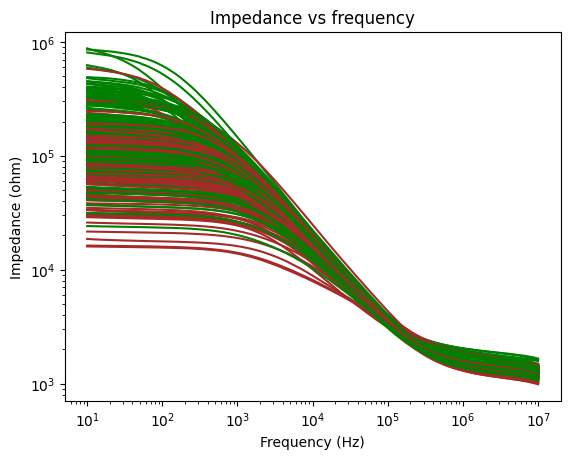

In [54]:
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedance (ohm)')
plt.title("Impedance vs frequency")
plt.xscale('log')
plt.yscale('log')

for i in range(0, len(LABELS) - 1):
    label = LABELS[i]
    impedance = IMPEDANCE_RESPONSE[i]
    phase_shift = PHASE_SHIFT_RESPONSE[i]
    if label:
        plt.plot(FREQUENCIES, IMPEDANCE_RESPONSE[i], 'brown')
    else:
        plt.plot(FREQUENCIES, IMPEDANCE_RESPONSE[i], 'green')
        
plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_impedance_vs_frequency.png"))

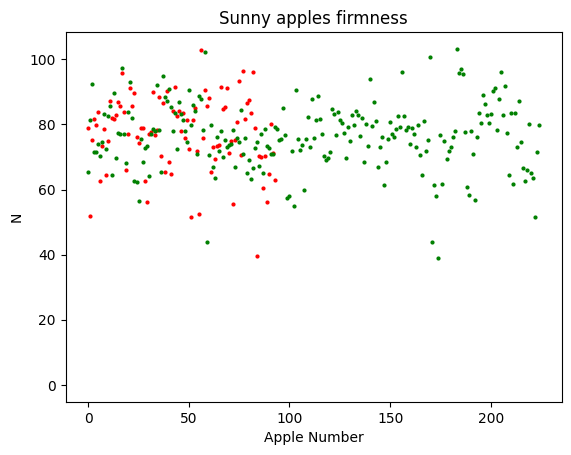

In [55]:
# Instrumental data analysis

# FIRMNESS

NOT_BROWNED_FIRMNESS_SUNNY = np.array([])
NOT_BROWNED_FIRMNESS_SHADY = np.array([])
BROWNED_FIRMNESS_SUNNY = np.array([])
BROWNED_FIRMNESS_SHADY = np.array([])

for val in INSTRUMENTAL_DATA:
    firmness_sunny = val[INSTRUMENTAL_COLUMNS.index("Dynamometer Sunny")]
    firmness_shady = val[INSTRUMENTAL_COLUMNS.index("Dynamometer Shady")]
    if val[INSTRUMENTAL_COLUMNS.index("Internal Browning")] != "No Browning":
        BROWNED_FIRMNESS_SUNNY = np.append(BROWNED_FIRMNESS_SUNNY, firmness_sunny)
        BROWNED_FIRMNESS_SHADY = np.append(BROWNED_FIRMNESS_SHADY, firmness_shady)
    else:
        NOT_BROWNED_FIRMNESS_SUNNY = np.append(NOT_BROWNED_FIRMNESS_SUNNY, firmness_sunny)
        NOT_BROWNED_FIRMNESS_SHADY = np.append(NOT_BROWNED_FIRMNESS_SHADY, firmness_shady)

plt.xlabel("Apple Number")
plt.ylabel("N")
plt.title("Sunny apples firmness")

markerline, stemlines, baseline = plt.stem(BROWNED_FIRMNESS_SUNNY, label='browned')
plt.setp(stemlines, 'color', 'none')
plt.setp(baseline, 'color', 'none')
plt.setp(markerline, 'markersize', 2)
plt.setp(markerline, 'color', 'red')

markerline, stemlines, baseline = plt.stem(NOT_BROWNED_FIRMNESS_SUNNY, label='not browned')
plt.setp(stemlines, 'color', 'none')
plt.setp(baseline, 'color', 'none')
plt.setp(markerline, 'markersize', 2)
plt.setp(markerline, 'color', 'green')

plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_firmness_sunny.png"))

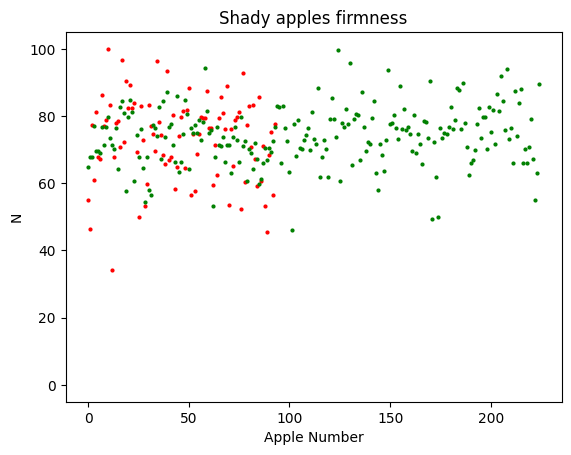

In [56]:
plt.xlabel("Apple Number")
plt.ylabel("N")
plt.title("Shady apples firmness")


markerline, stemlines, baseline = plt.stem(BROWNED_FIRMNESS_SHADY, label='browned')
plt.setp(stemlines, 'color', 'none')
plt.setp(baseline, 'color', 'none')
plt.setp(markerline, 'markersize', 2)
plt.setp(markerline, 'color', 'red')

markerline, stemlines, baseline = plt.stem(NOT_BROWNED_FIRMNESS_SHADY, label='not browned')
plt.setp(stemlines, 'color', 'none')
plt.setp(baseline, 'color', 'none')
plt.setp(markerline, 'markersize', 2)
plt.setp(markerline, 'color', 'green')


plt.savefig(os.path.join(FIGURE_FOLDER, "general_plotting_firmness_shady.png"))

In [57]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, learning_curve, cross_val_predict
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(estimator, X, y, cv):
    y_pred = cross_val_predict(estimator, X, y, cv=cv)
    cm = confusion_matrix(y, y_pred, normalize='all')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix ({estimator.__class__.__name__})')
    plt.show()

kf = KFold(n_splits=K_N_SPLITS, shuffle=True, random_state=42)

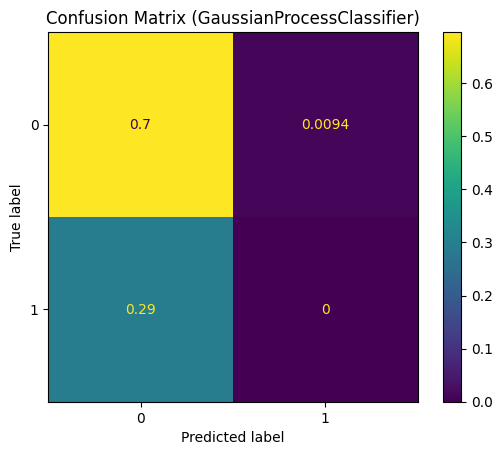

In [58]:
# Gaussian Process Classifier only with impedence and phase shift measures

X = np.hstack((IMPEDANCE_RESPONSE, PHASE_SHIFT_RESPONSE))
y = LABELS

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
cv_scores = cross_val_score(gpc, X, y, cv=kf, scoring='accuracy')

print("GAUSSIAN PROCESS CLASSIFIER ONLY WITH IMPEDENCE AND PHASE SHIFT MEASURES")
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)

print("Accuracy on the entire dataset:", accuracy_score(y_test, y_pred))
print("Classification Report on the entire dataset:\n", classification_report(y_test, y_pred))
print("\n\n")

plot_confusion_matrix(gpc, X, y, cv=kf)

/home/gmazzucchi/miniconda3/envs/rsp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gmazzucchi/miniconda3/envs/rsp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gmazzucchi/miniconda3/envs/rsp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

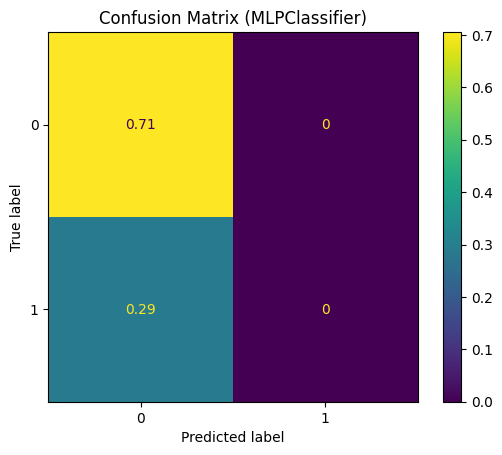

In [59]:
# Multi layer Perceptron only with impedence and phase shift measures

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
cv_scores = cross_val_score(mlp, X, y, cv=kf, scoring='accuracy')

print("MULTI LAYER PERCEPTRON ONLY WITH IMPEDENCE AND PHASE SHIFT MEASURES")
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Accuracy on the entire dataset:", accuracy_score(y_test, y_pred))
print("Classification Report on the entire dataset:\n", classification_report(y_test, y_pred))
print("\n\n")

plot_confusion_matrix(mlp, X, y, cv=kf)

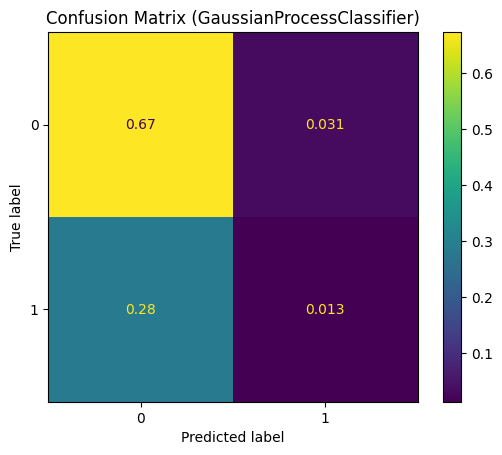

In [60]:
# Gaussian Process classifier using only instrumental data

X = INSTRUMENTAL_DATA_TABLE

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
cv_scores = cross_val_score(gpc, X, y, cv=kf, scoring='accuracy')

print("GAUSSIAN PROCESS CLASSIFIER USING ONLY INSTRUMENTAL DATA")
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)

print("Accuracy on the entire dataset:", accuracy_score(y_test, y_pred))
print("Classification Report on the entire dataset:\n", classification_report(y_test, y_pred))
print("\n\n")

plot_confusion_matrix(gpc, X, y, cv=kf)

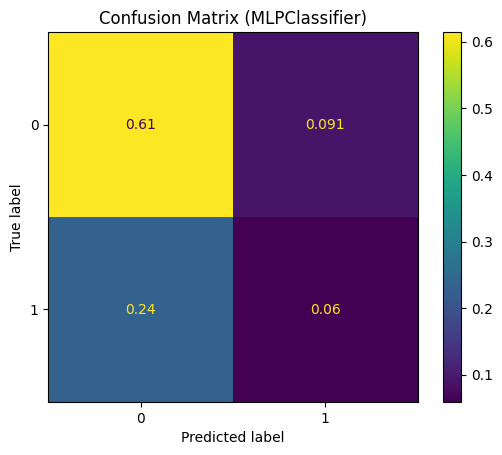

In [61]:
# Multi layer Perceptron only with instrumental data

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
cv_scores = cross_val_score(mlp, X, y, cv=kf, scoring='accuracy')

print("MULTI LAYER PERCEPTRON ONLY WITH INSTRUMENTAL DATA")
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Accuracy on the entire dataset:", accuracy_score(y_test, y_pred))
print("Classification Report on the entire dataset:\n", classification_report(y_test, y_pred))
print("\n\n")

plot_confusion_matrix(mlp, X, y, cv=kf)

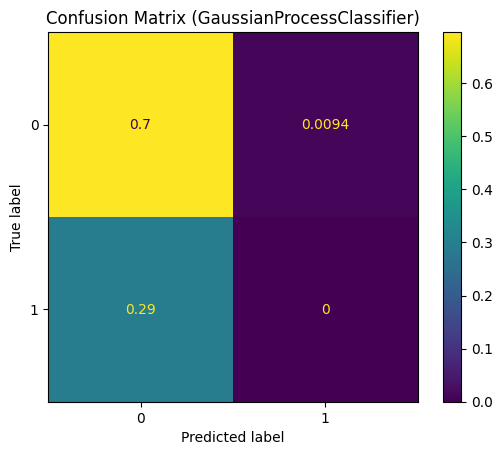

In [62]:
# Gaussian Process classifier using all features

X = np.hstack((IMPEDANCE_RESPONSE, PHASE_SHIFT_RESPONSE, INSTRUMENTAL_DATA_TABLE))

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
cv_scores = cross_val_score(gpc, X, y, cv=kf, scoring='accuracy')

print("GPC USING ALL FEATURES")
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
gpc.fit(X_train, y_train)
y_pred = gpc.predict(X_test)

print("Accuracy on the entire dataset:", accuracy_score(y_test, y_pred))
print("Classification Report on the entire dataset:\n", classification_report(y_test, y_pred))
print("\n\n")

plot_confusion_matrix(gpc, X, y, cv=kf)

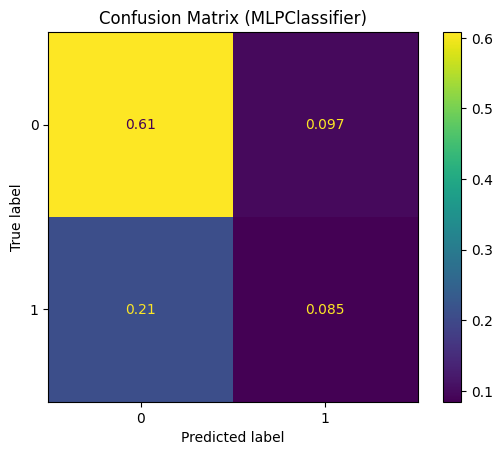

In [63]:
# MLP using all features

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=3000, random_state=42)
cv_scores = cross_val_score(mlp, X, y, cv=kf, scoring='accuracy')

print("MLP USING ALL FEATURES")
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", np.mean(cv_scores))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("Accuracy on the entire dataset:", accuracy_score(y_test, y_pred))
print("Classification Report on the entire dataset:\n", classification_report(y_test, y_pred))
print("\n\n")

plot_confusion_matrix(mlp, X, y, cv=kf)